In [3]:
pip install kneed

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

sns.set(rc={'figure.figsize':(15,6)})

In [5]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'
                  ,usecols=['Invoice','Quantity','InvoiceDate','Price','Customer ID'])
df = df.rename(columns={'Invoice':'order_id','Quantity':'quantity','InvoiceDate':'order_date',
                       'Price':'unit_price','Customer ID':'customer_id'})
df['line_price'] = df['unit_price'] * df['quantity']
df = df[df['line_price'] > 0]
df.head()

,order_id,quantity,order_date,unit_price,customer_id,line_price
0,489434,12,2009-12-01 07:45:00,6.95,13085.0,83.4
1,489434,12,2009-12-01 07:45:00,6.75,13085.0,81.0
2,489434,12,2009-12-01 07:45:00,6.75,13085.0,81.0
3,489434,48,2009-12-01 07:45:00,2.10,13085.0,100.8
4,489434,24,2009-12-01 07:45:00,1.25,13085.0,30.0


In [6]:
end_date = max(df['order_date']) + dt.timedelta(days=1)

df_rfm = df.groupby('customer_id').agg(
    recency=('order_date', lambda x: (end_date - x.max()).days),
    frequency=('order_id', 'count'),
    monetary=('line_price', 'sum')
)

df_rfm.head()

,recency,frequency,monetary
customer_id,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2671.14
12351.0,11,21,300.93


In [7]:
def preprocess(df):
    """Preprocess data for KMeans clustering"""

    df_log = np.log1p(df)
    scaler = StandardScaler()
    scaler.fit(df_log)
    df_norm = scaler.transform(df_log)

    return df_norm

In [8]:
def elbow_plot(df):
    """Create elbow plot from normalized data"""

    df_norm = preprocess(df)

    sse = {}

    for k in range(1, 21):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df_norm)
        sse[k] = kmeans.inertia_

    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

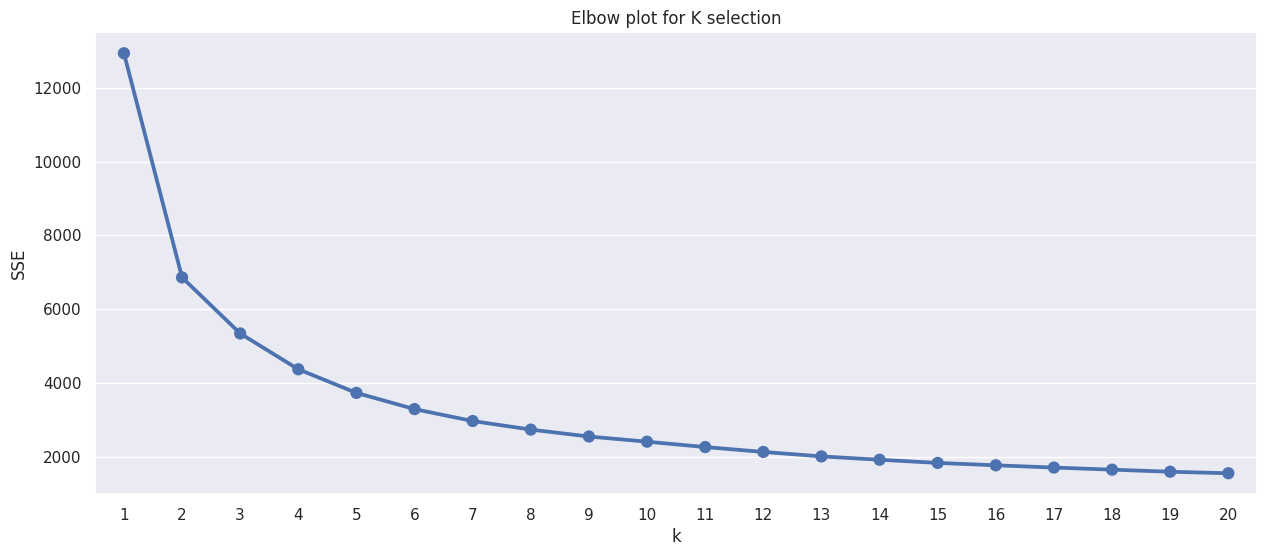

In [9]:
elbow_plot(df_rfm)

In [10]:
def find_k(df, increment=0, decrement=0):
    """Find the optimum k clusters"""

    df_norm = preprocess(df)
    sse = {}

    for k in range(1, 21):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df_norm)
        sse[k] = kmeans.inertia_

    kn = KneeLocator(x=list(sse.keys()),
                 y=list(sse.values()),
                 curve='convex',
                 direction='decreasing')
    k = kn.knee + increment - decrement
    return k

In [11]:
def run_kmeans(df, increment=0, decrement=0):
    """Run KMeans clustering, including the preprocessing of the data
    and the automatic selection of the optimum k.
    """

    df_norm = preprocess(df)
    k = find_k(df, increment, decrement)
    kmeans = KMeans(n_clusters=k,
                    random_state=1)
    kmeans.fit(df_norm)
    return df.assign(cluster=kmeans.labels_)

In [12]:
clusters = run_kmeans(df_rfm)
clusters.groupby('cluster').agg(
    recency=('recency','mean'),
    frequency=('frequency','mean'),
    monetary=('monetary','mean'),
    cluster_size=('monetary','count')
).round(1).sort_values(by='recency')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,recency,frequency,monetary,cluster_size
cluster,,,,
1,9.6,315.3,7936.4,657
0,20.7,39.6,618.7,852
4,66.3,121.8,2278.5,1036
3,169.4,31.8,543.6,1138
2,171.4,7.0,177.4,629


In [13]:
clusters_increment = run_kmeans(df_rfm, increment=1)
clusters_increment.groupby('cluster').agg(
    recency=('recency','mean'),
    frequency=('frequency','mean'),
    monetary=('monetary','mean'),
    cluster_size=('monetary','count')
).round(1).sort_values(by='recency')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,recency,frequency,monetary,cluster_size
cluster,,,,
0,10.6,96.8,1428.6,641
2,13.6,403.7,10629.4,467
5,35.7,24.0,454.9,824
4,76.9,109.0,2093.6,974
3,191.5,6.2,159.3,507
1,198.5,31.2,509.0,899
